In [6]:
import datetime
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
import seaborn as sns
sns.set()
import numpy as np
from scipy.stats import norm
from sklearn.metrics import silhouette_score, calinski_harabaz_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from scipy import stats
import missingno as msno
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = (15,10)

In [7]:
import os
print(os.listdir("."))

['dimension_rollup_periods.csv', 'CustomerCliffDive.pdf', 'yammer_emails.csv', 'README.md', 'yammer_events_1.csv', 'yammer_events_2.csv', 'Yves_Greatti_DC3.ipynb', 'Submissions', '.ipynb_checkpoints', 'yammer_users.csv']


# Customer Cliff Dive

What caused the drop in user engagement? 

Based on what you observe in the data, what recommendations would you make to the organization?


In [8]:
def log_missing_data(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print(missing_data.head())

In [9]:
users_df = pd.read_csv('yammer_users.csv')
users_df.shape

(19066, 6)

In [10]:
users_df['user_id'] = users_df['user_id'].astype('int')
users_df['company_id'] = users_df['company_id'].astype('int')
users_df['created_at'] =  pd.to_datetime(users_df['created_at'])
users_df['activated_at'] =  pd.to_datetime(users_df['activated_at'])
users_df['state'] = pd.Categorical(users_df['state'])

In [11]:
users_df.dtypes

user_id                  int64
created_at      datetime64[ns]
company_id               int64
language                object
activated_at    datetime64[ns]
state                 category
dtype: object

In [12]:
users_df.head()

,user_id,created_at,company_id,language,activated_at,state
0,0,2013-01-01 20:59:39,5737,english,2013-01-01 21:01:07,active
1,1,2013-01-01 13:07:46,28,english,NaT,pending
2,2,2013-01-01 10:59:05,51,english,NaT,pending
3,3,2013-01-01 18:40:36,2800,german,2013-01-01 18:42:02,active
4,4,2013-01-01 14:37:51,5110,indian,2013-01-01 14:39:05,active


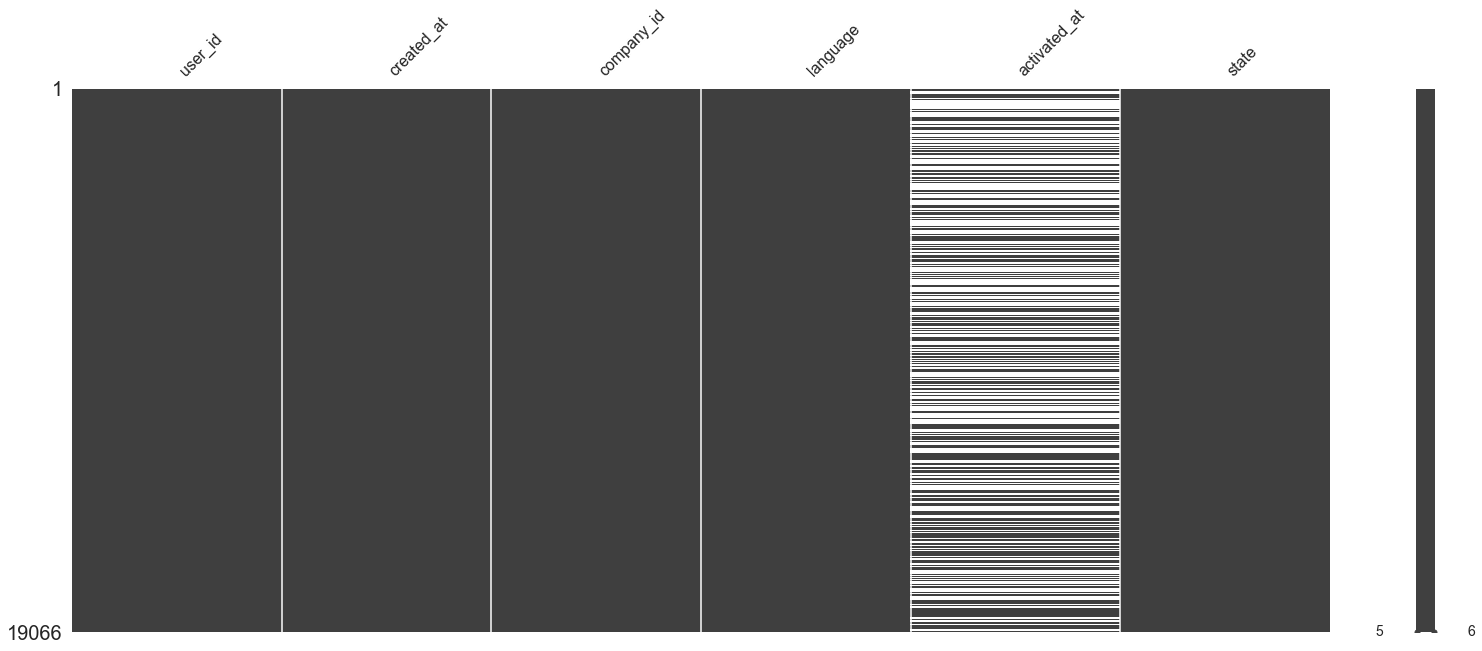

In [13]:
msno.matrix(users_df)

In [14]:
log_missing_data(users_df)

              Total    Percent
activated_at   9685  50.797231
state             0   0.000000
language          0   0.000000
company_id        0   0.000000
created_at        0   0.000000


In [15]:
active_users = users_df[users_df['state'] == 'active']
active_users.count()

user_id         9381
created_at      9381
company_id      9381
language        9381
activated_at    9381
state           9381
dtype: int64

In [16]:
events1_df = pd.read_csv('yammer_events_1.csv')
events1_df.shape

(170416, 8)

In [17]:
events2_df = pd.read_csv('yammer_events_2.csv')

In [18]:
events_df = pd.concat([events1_df, events2_df])
events_df = events_df.reset_index(drop=True)
events_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [19]:
events_df['user_id'] = events_df['user_id'].astype('int')
events_df['occurred_at'] =  pd.to_datetime(events_df['occurred_at'])
events_df['event_type'] = pd.Categorical(events_df['event_type'])
events_df['event_name'] = pd.Categorical(events_df['event_name'])
events_df['location'] = events_df['location'].astype('str')
events_df['device'] = events_df['device'].astype('str')

Only 'signup_flow' users have na as user_type. We drop them as we are only interested by active users.

In [20]:
events_df = events_df[events_df['user_type'].notna()]
events_df['user_type'] = events_df['user_type'].astype('int')

In [21]:
events_df.dtypes

user_id                 int64
occurred_at    datetime64[ns]
event_type           category
event_name           category
location               object
device                 object
user_type               int64
dtype: object

In [22]:
events_df.head()

,user_id,occurred_at,event_type,event_name,location,device,user_type
0,10522,2014-05-02 11:02:39,engagement,login,Japan,dell inspiron notebook,3
1,10522,2014-05-02 11:02:53,engagement,home_page,Japan,dell inspiron notebook,3
2,10522,2014-05-02 11:03:28,engagement,like_message,Japan,dell inspiron notebook,3
3,10522,2014-05-02 11:04:09,engagement,view_inbox,Japan,dell inspiron notebook,3
4,10522,2014-05-02 11:03:16,engagement,search_run,Japan,dell inspiron notebook,3


In [23]:
log_missing_data(events_df)

            Total  Percent
user_type       0      0.0
device          0      0.0
location        0      0.0
event_name      0      0.0
event_type      0      0.0


In [24]:
emails_df = pd.read_csv('yammer_emails.csv')
emails_df.shape

(90389, 4)

In [25]:
emails_df['user_id'] = emails_df['user_id'].astype('int')
emails_df['occurred_at'] =  pd.to_datetime(emails_df['occurred_at'])
emails_df['action'] = pd.Categorical(emails_df['action'])
emails_df['user_type'] = emails_df['user_type'].astype('int')
emails_df['user_type'] =  pd.Categorical(emails_df['user_type'])

In [26]:
emails_df.dtypes

user_id                 int64
occurred_at    datetime64[ns]
action               category
user_type            category
dtype: object

In [27]:
emails_df.head()

,user_id,occurred_at,action,user_type
0,0,2014-05-06 09:30:00,sent_weekly_digest,1
1,0,2014-05-13 09:30:00,sent_weekly_digest,1
2,0,2014-05-20 09:30:00,sent_weekly_digest,1
3,0,2014-05-27 09:30:00,sent_weekly_digest,1
4,0,2014-06-03 09:30:00,sent_weekly_digest,1


In [28]:
log_missing_data(emails_df)

             Total  Percent
user_type        0      0.0
action           0      0.0
occurred_at      0      0.0
user_id          0      0.0


In [29]:
print('Duplicate entries for emails: {}'.format(emails_df.duplicated().sum()))

Duplicate entries for emails: 0


In [30]:
active_user_events = pd.merge(events_df,
                 active_users[['user_id','state']],
                 on='user_id',
                 how='inner')
active_user_events = active_user_events[active_user_events['event_type'] == 'engagement']
active_user_events.head()

,user_id,occurred_at,event_type,event_name,location,device,user_type,state
0,10522,2014-05-02 11:02:39,engagement,login,Japan,dell inspiron notebook,3,active
1,10522,2014-05-02 11:02:53,engagement,home_page,Japan,dell inspiron notebook,3,active
2,10522,2014-05-02 11:03:28,engagement,like_message,Japan,dell inspiron notebook,3,active
3,10522,2014-05-02 11:04:09,engagement,view_inbox,Japan,dell inspiron notebook,3,active
4,10522,2014-05-02 11:03:16,engagement,search_run,Japan,dell inspiron notebook,3,active


In [31]:
print(min(active_user_events['occurred_at']))
print(max(active_user_events['occurred_at']))

2014-05-01 02:27:15
2014-08-31 23:03:39


In [32]:
# active_user_events_ts = active_user_events.copy()
# active_user_events_ts['occurred_at'] = pd.to_datetime(active_user_events_ts['occurred_at'])
# active_user_events_ts = active_user_events_ts.set_index('occurred_at')
# active_user_events_ts.head()

In [33]:
# active_user_events_ts  = active_user_events_ts.groupby('occurred_at').user_id.nunique().resample('W').size().reset_index(name='counts')
# active_user_events_ts['occurred_at'] = pd.to_datetime(active_user_events_ts['occurred_at'])
# active_user_events_ts = active_user_events_ts.set_index('occurred_at')
# active_user_events_ts = active_user_events_ts['2014-05-01':'2014-09-01']
# ax = active_user_events_ts.plot(legend=False, figsize=(10,8), lw=2, color='red', marker='.', markersize=10, title='Active users');
# ax.set_xlabel("Months")
# ax.set_ylabel("Counts")
# plt.grid(True)
# plt.show()

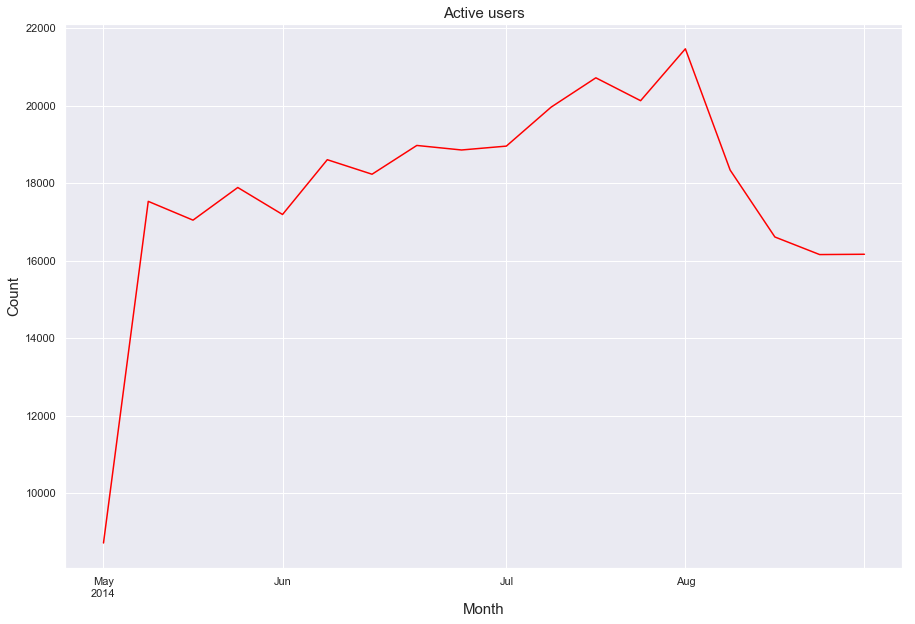

In [34]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
active_user_events_ts = pd.DatetimeIndex(pd.Series(active_user_events.occurred_at))
active_user_events_ts_toBePlotted = pd.Series(1, index=active_user_events_ts)
ax.set_title('Active users', fontsize=15)
active_user_events_ts_toBePlotted.resample('W').sum().plot(color='red')
ax.set_xlabel('Month', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
plt.show()

Dip is confirmed at the end of August

In [47]:
def map_to_quarter(x):
    if x >= datetime.date(2013, 1, 1) and x < datetime.date(2013, 4, 1):
        return '2013 Q1'
    elif x >= datetime.date(2013, 4, 1) and x < datetime.date(2013, 7, 1):
        return '2013 Q2'
    elif x >= datetime.date(2013, 7, 1) and x < datetime.date(2013, 10, 1):
        return '2013 Q3'
    elif x >= datetime.date(2013, 10, 1) and x < datetime.date(2014, 1, 1):
        return '2013 Q4'
    elif x >= datetime.date(2014, 1, 1) and x < datetime.date(2014, 4, 1):
        return '2014 Q1'
    elif x >= datetime.date(2014, 4, 1) and x < datetime.date(2014, 7, 1):
        return '2014 Q2'
    elif x >= datetime.date(2014, 7, 1) and x < datetime.date(2014, 10, 1):
        return '2014 Q3'
    elif x >= datetime.date(2014, 10, 1) and x < datetime.date(2014, 1, 1):
        return '2014 Q4'

active_user_per_quarter = users_df.copy()
active_user_per_quarter['created_at'] = pd.to_datetime(active_user_per_quarter['created_at'], format="%m/%d/%Y").dt.date
active_user_per_quarter['created_at'] = active_user_per_quarter['created_at'].apply(map_to_quarter)
active_user_per_quarter = active_user_per_quarter.groupby(['created_at']).size()
active_user_per_quarter

created_at
2013 Q1    1043
2013 Q2    1381
2013 Q3    1943
2013 Q4    2614
2014 Q1    3368
2014 Q2    4744
2014 Q3    3973
dtype: int64

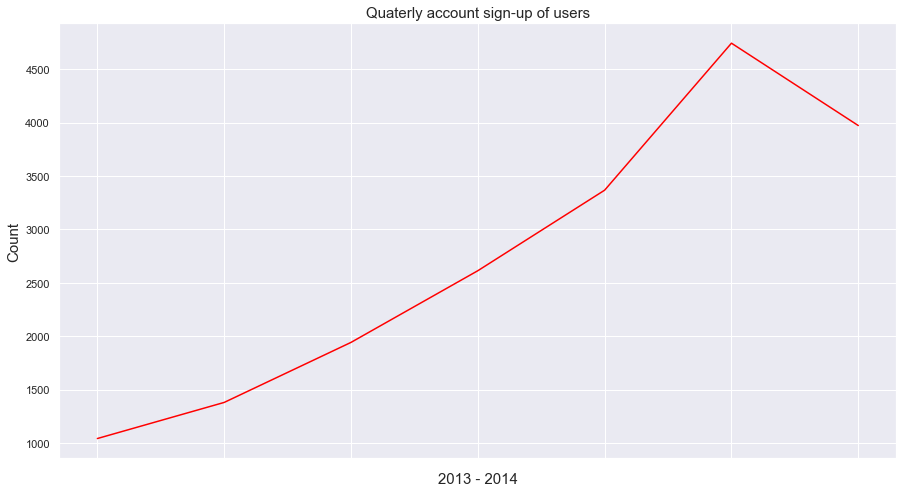

In [36]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title('Quaterly account sign-up of users', fontsize=15)
active_user_per_quarter.plot(ax=ax, color='red');
ax.set_xlabel('2013 - 2014', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
plt.show()

In [194]:
new_users_df  = users_df.groupby('activated_at').user_id.nunique().resample('W').size().reset_index(name='counts')

In [195]:
print(min(new_users_df['activated_at']))
print(max(new_users_df['activated_at']))

2013-01-06 00:00:00
2014-08-31 00:00:00


In [196]:
new_users_df['activated_at'] = pd.to_datetime(new_users_df['activated_at'])
new_users_df = new_users_df.set_index('activated_at')
new_users_df = new_users_df['2014-05-01':'2014-09-01']

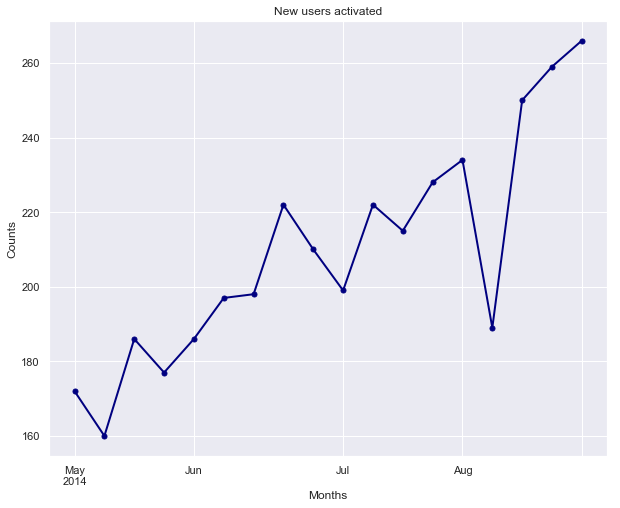

In [197]:
ax = new_users_df.plot(legend=False, figsize=(10,8), lw=2, colormap='jet', marker='.', markersize=10, title='New users activated');
ax.set_xlabel("Months")
ax.set_ylabel("Counts")
plt.grid(True)

New users were also affected around the end of month of August.

In [198]:
computer_list = ['macbook pro','lenovo thinkpad','macbook air','dell inspiron notebook',
          'asus chromebook','dell inspiron desktop','acer aspire notebook','hp pavilion desktop','acer aspire desktop','mac mini']
phone_list = ['iphone 5','samsung galaxy s4','nexus 5','iphone 5s','iphone 4s','nokia lumia 635',
       'htc one','samsung galaxy note','amazon fire phone']
tablet_list = ['ipad air','nexus 7','ipad mini','nexus 10','kindle fire','windows surface', 'samsumg galaxy tablet']
    
def map_to_device(x):
    if x in computer_list:
        return 'computer'
    elif x in phone_list:
        return 'phone'
    elif x in tablet_list:
        return 'tablet'
active_user_events_per_device = active_user_events.copy()
active_user_events_per_device['device_type'] = active_user_events_per_device['device'].apply(map_to_device)
active_user_events_per_device.head()

,user_id,occurred_at,event_type,event_name,location,device,user_type,state,device_type
0,10522,2014-05-02 11:02:39,engagement,login,Japan,dell inspiron notebook,3,active,computer
1,10522,2014-05-02 11:02:53,engagement,home_page,Japan,dell inspiron notebook,3,active,computer
2,10522,2014-05-02 11:03:28,engagement,like_message,Japan,dell inspiron notebook,3,active,computer
3,10522,2014-05-02 11:04:09,engagement,view_inbox,Japan,dell inspiron notebook,3,active,computer
4,10522,2014-05-02 11:03:16,engagement,search_run,Japan,dell inspiron notebook,3,active,computer


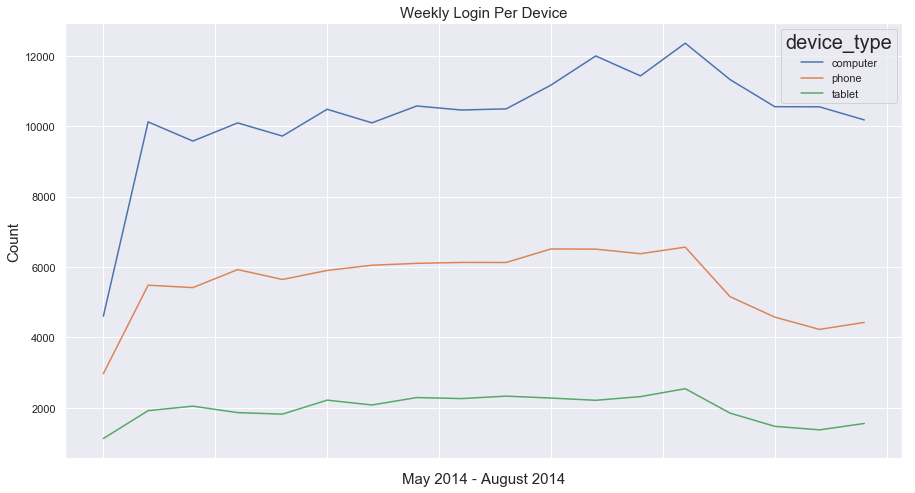

In [199]:
active_user_events_per_device['Week/Year'] = active_user_events_per_device['occurred_at'].apply(lambda x: "%d/%d" % (x.week, x.year))
active_user_events_per_device = active_user_events_per_device.groupby(['Week/Year', 'device_type']).size()
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title('Weekly Login Per Device', fontsize=15)
active_user_events_per_device.unstack().plot(ax=ax);
ax.set_xlabel('May 2014 - August 2014', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
plt.show()

Notice a significant decrease with users logging in with phone. Maybe there is an issue with Yammer's mobile app?

In [174]:
active_user_events_by_event_name = active_user_events.copy()
active_user_events_by_event_name['Week/Year'] = active_user_events_by_event_name['occurred_at'].apply(lambda x: "%d/%d" % (x.week, x.year))
active_user_events_by_event_name = active_user_events_by_event_name.groupby(['Week/Year', 'event_name']).size()
active_user_events_by_event_name.head()

Week/Year  event_name           
18/2014    home_page                2546
           like_message             1657
           login                     967
           search_autocomplete       424
           search_click_result_1      44
dtype: int64

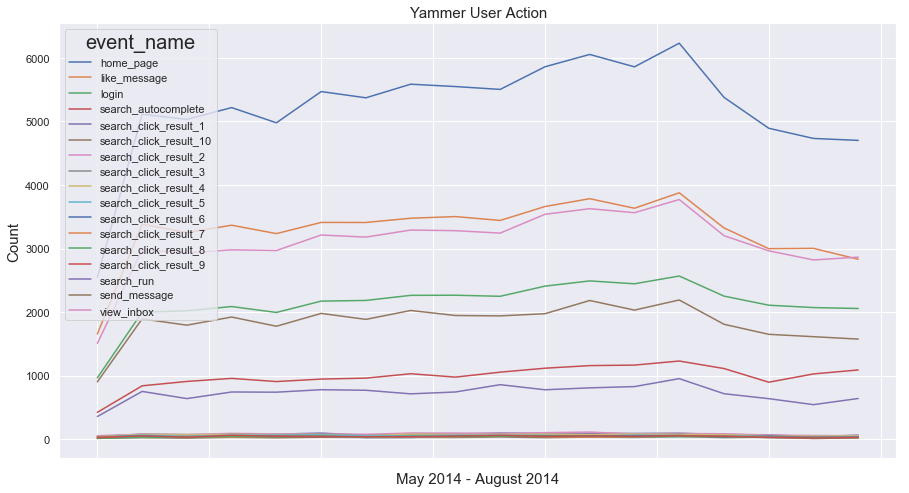

In [175]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title('Yammer User Action', fontsize=15)
active_user_events_by_event_name.unstack().plot(ax=ax);
ax.set_xlabel('May 2014 - August 2014', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
plt.show()

Users loading the home page dropped significantly, including 'like_message' and 'search_autocomplete' features.

In [200]:
active_user_emails = pd.merge(emails_df,
                 active_users[['user_id']],
                 on='user_id',
                 how='inner')
active_user_emails.head()

,user_id,occurred_at,action,user_type
0,0,2014-05-06 09:30:00,sent_weekly_digest,1
1,0,2014-05-13 09:30:00,sent_weekly_digest,1
2,0,2014-05-20 09:30:00,sent_weekly_digest,1
3,0,2014-05-27 09:30:00,sent_weekly_digest,1
4,0,2014-06-03 09:30:00,sent_weekly_digest,1


In [201]:
active_user_emails['Week/Year'] = active_user_emails['occurred_at'].apply(lambda x: "%d/%d" % (x.week, x.year))
active_user_emails = active_user_emails.groupby(['Week/Year', 'action']).size()
active_user_emails.head()

Week/Year  action                 
18/2014    email_clickthrough         187
           email_open                 332
           sent_reengagement_email     98
           sent_weekly_digest         908
19/2014    email_clickthrough         434
dtype: int64

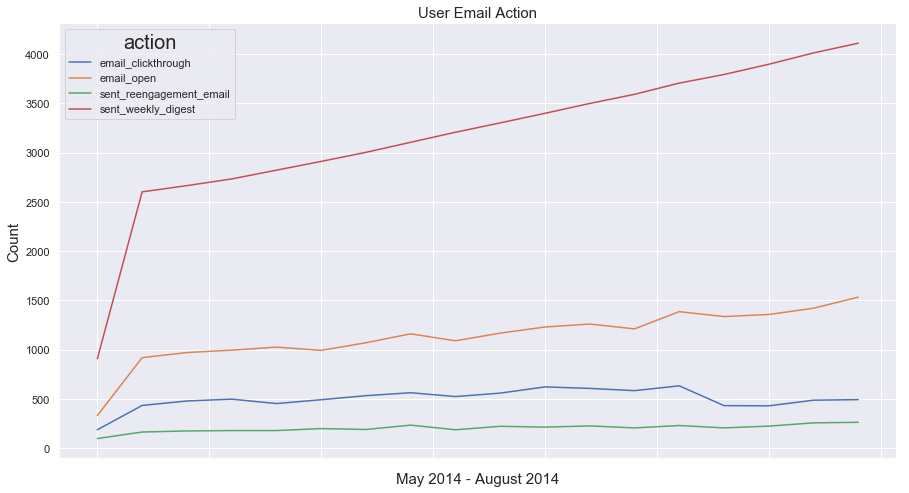

In [202]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title('User Email Action', fontsize=15)
active_user_emails.unstack().plot(ax=ax);
ax.set_xlabel('May 2014 - August 2014', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
plt.show()

Weekly digest emails go to the roof, and clickthroughs are way down. 

In [244]:
active_user_events_by_location = active_user_events.copy()
active_user_events_by_location['Week/Year'] = active_user_events_by_location['occurred_at'].apply(lambda x: "%d/%d" % (x.week, x.year))
active_user_events_by_location = active_user_events_by_location.groupby(['Week/Year', 'location']).size()
#active_user_events_by_location.sort_values(by='col1', ascending=False)
#df4 = active_user_events_by_location.reset_index(name='count')
#active_user_events_by_location.sort_values(ascending=False)
active_user_events_by_location.head()

#df4.columns
#df4.sort_values('count', inplace=True, ascending=False)
#df4.head()

Week/Year  location 
18/2014    Argentina      8
           Australia    247
           Austria       33
           Belgium      130
           Brazil       278
dtype: int64

In [248]:
us_users = active_user_events_by_location.reset_index(name='count')
us_users = us_users[us_users['location'] == 'United States']
us_users.head()

,Week/Year,location,count
44,18/2014,United States,2425
91,19/2014,United States,4600
137,20/2014,United States,4637
184,21/2014,United States,4359
231,22/2014,United States,4276


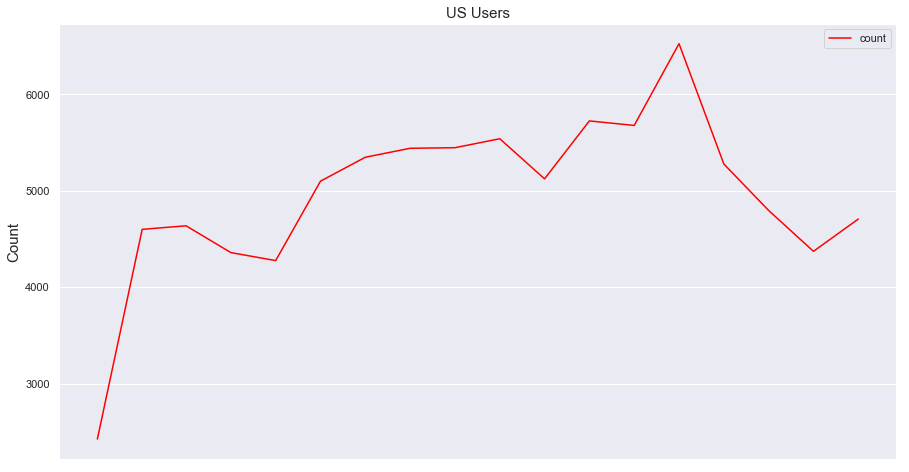

In [253]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title('US Users', fontsize=15)
us_users.plot(ax=ax, color='red');
ax.set_xlabel('May 2014 - August 2014', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
x_axis = ax.axes.get_xaxis()
x_axis.set_visible(False)
plt.show()